# Preprocesamiento

Una vez que definimos las columnas, o variables, que utilizaremos en la construcción del dataset recurrimos a reglas del negocio para saber como tratar los valores *en blanco* o nulos

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
datos = pd.read_csv('Base Jessica Vega Feb 2020 Depurada.csv')
datos.columns
# no requerimos de algunas columnas para el modelo de clasificacion 
datos[['LONG']] =  -1*datos[['LONG']]
# para poder imputar los valores que no se tienen de la variable 'SALDO_CONTRATO', los ceros, 
# nos fijamos en su distribucion 
# datos[['SALDO_CONTRATO']].hist()
datos[['SALDO_CONTRATO']].describe()
# imputamos la variable datos[['SALDO_CONTRATO']] por la mediana pues hay valores muy grandes y usar la media sesga más
datos['SALDO_CONTRATO'].replace({ -1: np.median(datos.SALDO_CONTRATO)}, inplace=True)
datos['SALDO_CONTRATO'].replace({ 0: np.median(datos.SALDO_CONTRATO)}, inplace=True)

# para poder imputar los valores que no se tienen de la variable 'SALDO_CLIENTE', los ceros, 
# nos fijamos en su distribucion 
# datos[['SALDO_CLIENTE']].hist()
datos[['SALDO_CLIENTE']].describe()
# imputamos la variable datos[['SALDO_CLIENTE']] por la mediana pues hay valores muy grandes y usar la media sesga más
datos['SALDO_CLIENTE'].replace({ 0: np.median(datos.SALDO_CLIENTE)}, inplace=True)
datos['SALDO_CLIENTE'].replace({ -1: np.median(datos.SALDO_CLIENTE)}, inplace=True)
# para imputar el tipo de cliente, variable 'DESC_TIPO_PERS' lo hacemos por reglas del degocio. La mayoria de clientes son personas fisicas
datos.DESC_TIPO_PERS.value_counts
datos[['DESC_TIPO_PERS']] = datos[['DESC_TIPO_PERS']].fillna(value='PERSONA FISICA')
# para imputar la variable a predecir el tipo de cliente, variable 'STATUS_BE'
# lo hacemos por reglas del degocio, si el cliente tiene dado de alta la banca electronica lo marcamos como 1 y 0 en otro caso 
datos[['STATUS_BE']] = datos[['STATUS_BE']].fillna(value='NO_ENROLADO')
datos['STATUS_BE'].replace({ 'NO_ENROLADO': 0, 'ENROLADO':1}, inplace=True)
datos['STATUS_BE'] = datos['STATUS_BE'].astype('int64')
# finalmente como la mayoria de las columnas son nominales las transformamos a dummies y realizamos un escalamiento
del datos['CLAVE_CLIENTE']
datos['UNIDAD_NEGOCIO'] = datos['UNIDAD_NEGOCIO'].astype('category')
datos['EMISORA_FONDO'] = datos['EMISORA_FONDO'].astype('category')
#datos['DESC_TIPO_PERS'] = datos['DESC_TIPO_PERS'].astype('category')
datos['ENTIDAD_FEDERATIVA'] = datos['ENTIDAD_FEDERATIVA'].astype('category')
datos['GENERO'] = datos['GENERO'].astype('category')

Como el alcance del proyecto es a personas físicas omitiremos de nuestro dataset el conjunto de personas morales. 

In [2]:
index = datos[ datos['DESC_TIPO_PERS'] == 'PERSONA MORAL'].index
datos.drop(index, inplace=True)
#############
index = datos[ datos['EDAD'] == 'PM'].index
datos.drop(index, inplace=True)
index = datos[ datos['CATEGORIA_OP'].isna() ].index # reemplazamos el nulo por un string
datos['CATEGORIA_OP'][index] = 'NULO'
datos['CATEGORIA_OP'] = datos['CATEGORIA_OP'].astype('category')
datos = datos.reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


En el analisis exploratorio de los datos se encontró que la variable ‘SALDO_CONTRATO’ y ‘SALDO_CLIENTE’ estan altamente correlacionadas (al 99%), por lo que descartamos la primera y solo trabajaremos con la segunda.

[[1.         0.99595778]
 [0.99595778 1.        ]]


,EDAD
count,3253.000000
mean,53.705810
std,15.507542
min,6.000000
25%,43.000000
50%,53.000000
75%,64.000000
max,109.000000


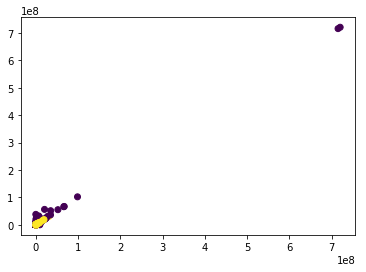

In [3]:
import matplotlib.pyplot as plt
plt.scatter(datos['SALDO_CONTRATO'], datos['SALDO_CLIENTE'], c = datos['STATUS_BE'])
print(np.corrcoef(datos['SALDO_CONTRATO'], datos['SALDO_CLIENTE']))
del datos['SALDO_CONTRATO']
datos['EDAD'] = datos['EDAD'].astype('int64')
datos[['EDAD']].describe()

Notamos que la distribución geográfica de los usuarios Actinver presentes en el dataset se encuentran principalmente en la CDMX y en el estado de Jalisco.

In [4]:
mapa = datos[['LAT', 'LONG', 'DESC_CE_FINANCIERO']]
mapa = mapa.dropna()
import folium
from folium import plugins
mapit = folium.Map( location = mapa[['LAT', 'LONG']].mean(), zoom_start = 5)
marker_cluster_ = folium.plugins.MarkerCluster()
for idx in range(0,len(mapa) ):
    marker_ = folium.Marker( location = mapa[  ['LAT', 'LONG'] ].iloc[idx],   
                           icon = folium.Icon(color='red') )
    marker_cluster_.add_child(marker_)
mapit.add_child(marker_cluster_)

In [5]:
datos[[ 'SALDO_CLIENTE', 'STATUS_BE' ]].groupby( [ 'STATUS_BE']).describe()

SALDO_CLIENTE                                                 \
                  count          mean           std   min          25%   
STATUS_BE                                                                
0                2312.0  2.008990e+06  2.154260e+07  0.01  111329.0525   
1                 941.0  5.105116e+05  1.582061e+06  0.03   86169.5800   

                                                 
                  50%         75%           max  
STATUS_BE                                        
0          342898.355  1011872.01  7.203282e+08  
1          204320.650   400937.83  3.079402e+07

En la siguiente gráfica mostramos un diagrama de caja y bigotes de la variable ‘SALDO_CLIENTE’, donde notamos que los clientes que usan los servicios de la banca electrónica (‘STATUS_BE’ == 1) tienen en general una mediana menor a los que no usan los servicios electrónicos, sin embargo el conjunto de clientes que usan los servicios digitales tienen una menor variabilidad y outliers con menor saldo. 

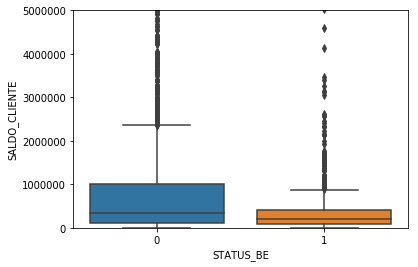

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.ylim([0, 5000000])
g = sns.boxplot(x = 'STATUS_BE', y = 'SALDO_CLIENTE', data=datos[[ 'SALDO_CLIENTE', 'STATUS_BE' ]])

Al observar la edad de los clientes por su estatus en los servicios electrónicos notamos que los usuarios que usan los servicios digitales presentan una edad menor que los que no la utilizan, al igual que en la variable de saldo en sus cuentas estos presentan menor variabilidad en la edad.

             EDAD                                                      
            count       mean        std   min    25%   50%   75%    max
STATUS_BE                                                              
0          2312.0  55.216263  15.861553   6.0  44.75  55.0  66.0  109.0
1           941.0  49.994687  13.929800  20.0  40.00  49.0  59.0   90.0


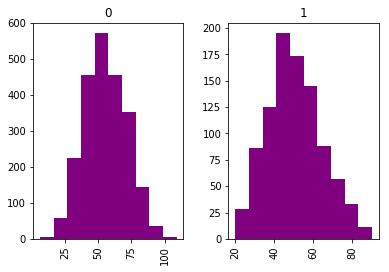

In [7]:
datos.hist(by ='STATUS_BE', column='EDAD', color=['purple'])
print(datos[[ 'EDAD', 'STATUS_BE' ]].groupby( [ 'STATUS_BE']).describe())

In [8]:
x = datos[['GENERO', 'STATUS_BE', 'EDAD']].dropna()
x.reset_index(drop=True)
x = x.groupby(['GENERO', 'STATUS_BE']).count()
x = x.dropna().reset_index()
x.columns = ['GENERO', 'STATUS_BE', 'CONTEO']

Finalmente observamos que los usuarios que sí hacen uso de los servicios electrónicos son en su mayoría varones, mientras que el genero de los clientes que no usan la banca electrónica se distribuye equitativamente. 

Text(0.5,0.98,'Clientes con banca electrónica (genero)')

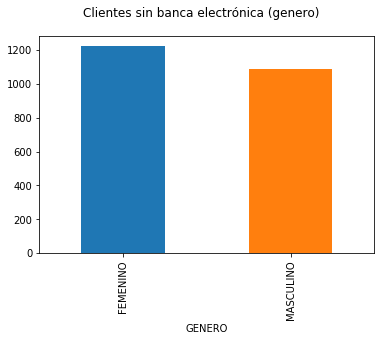

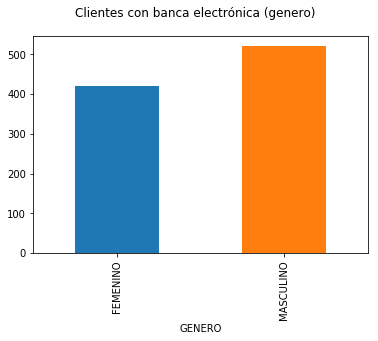

In [9]:
x[ x['STATUS_BE'] == 0 ].plot.bar(x='GENERO', y='CONTEO', legend=False)
plt.suptitle("Clientes sin banca electrónica (genero)")
x[ x['STATUS_BE'] == 1 ].plot.bar(x='GENERO', y='CONTEO', legend=False)
plt.suptitle("Clientes con banca electrónica (genero)")